In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt


crashsite_df = pd.read_csv("data/Road_Crashes_for_five_Years_Victoria.csv",parse_dates=["ACCIDENT_DATE"])
crashsite_df.head()

,X,Y,OBJECTID,ACCIDENT_NO,ABS_CODE,ACCIDENT_STATUS,ACCIDENT_DATE,ACCIDENT_TIME,ALCOHOLTIME,ACCIDENT_TYPE,...,DEG_URBAN_ALL,LGA_NAME_ALL,REGION_NAME_ALL,SRNS,SRNS_ALL,RMA,RMA_ALL,DIVIDED,DIVIDED_ALL,STAT_DIV_NAME
0,2444652.517,2369157.816,1,T20150013818,ABS to receive accident,Finished,2015-07-01 00:00:00+00:00,1899/12/30 05:15:00+00,Yes,Collision with a fixed object,...,LARGE_PROVINCIAL_CITIES,GEELONG,SOUTH WESTERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country
1,2507053.522,2427188.691,2,T20150013844,ABS to receive accident,Finished,2015-07-01 00:00:00+00:00,1899/12/30 11:30:00+00,No,Collision with a fixed object,...,MELB_URBAN,WHITTLESEA,METROPOLITAN NORTH WEST REGION,C,C,Arterial Other,"Arterial Other,Local Road",Divided,"Undivided,Divided",Metro
2,2490706.473,2409439.682,3,T20150013854,ABS to receive accident,Finished,2015-07-01 00:00:00+00:00,1899/12/30 13:40:00+00,No,Collision with vehicle,...,MELB_URBAN,MARIBYRNONG,METROPOLITAN NORTH WEST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro
3,2524370.961,2379929.797,4,T20150013897,Non ABS accident,Finished,2015-07-02 00:00:00+00:00,1899/12/30 10:31:00+00,No,Struck Pedestrian,...,MELB_URBAN,CASEY,METROPOLITAN SOUTH EAST REGION,NaN,NaN,NaN,NaN,NaN,NaN,Metro
4,2346439.879,2385852.164,5,T20150013907,ABS to receive accident,Finished,2015-07-02 00:00:00+00:00,1899/12/30 10:25:00+00,No,Vehicle overturned (no collision),...,RURAL_VICTORIA,CORANGAMITE,SOUTH WESTERN REGION,C,C,Arterial Other,Arterial Other,Undivided,Undivided,Country


```mermaid

flowchart LR

GPS -->|get location group using DBSCAN|location_cluster --> location_cluster_signature -->|get location cluster signature|ClustersOFtheSignature

```

In [2]:
from sklearn.cluster import DBSCAN

last_data = crashsite_df['ACCIDENT_DATE'].max()
last_data_year = last_data - pd.DateOffset(years=3)
last_data_year


last_year_selection = (crashsite_df['ACCIDENT_DATE'] > last_data_year) & (crashsite_df['ACCIDENT_DATE'] <= last_data)
lat_long_df = crashsite_df[last_year_selection][['LATITUDE', 'LONGITUDE']]
lat_long_df.head()



,LATITUDE,LONGITUDE
12807,-38.023162,144.414901
12851,-37.991876,145.215479
12852,-37.823054,147.628543
12853,-37.972613,145.236357
12854,-36.746840,144.258619


In [3]:
lat_long_df.shape

(43390, 2)

In [4]:
#https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data#:~:text=You%20can%20cluster%20spatial%20latitude,without%20precomputing%20a%20distance%20matrix.&text=This%20comes%20from%20this%20tutorial,to%20convert%20it%20to%20radians.
distance = np.array([0.01,0.05]) #k meters
eps_range = distance / 6371 # approx
eps_range


array([1.56961231e-06, 7.84806153e-06])

In [5]:

eps_data = []
for _eps in np.linspace(eps_range[0], eps_range[1], 100):
    clustering = DBSCAN(
        _eps, min_samples=5,
        algorithm='ball_tree',
        metric='haversine' # haversine is the distance between two points on a sphere 
        ).fit(np.radians(lat_long_df)) #need to be radians for haversine
    _eps_data = {
        "eps": _eps,
        "num_clusters": len(set(clustering.labels_)),
        "num_outliers": len([x for x in clustering.labels_ if x == -1])
    }
    eps_data.append(_eps_data)


In [6]:
clustering_data = pd.DataFrame(eps_data)
clustering_data["km_distance"] = clustering_data["eps"]*6371

clustering_data.sort_values(by=['num_clusters']).iloc[-1]

selected_eps = clustering_data.sort_values(by=['num_clusters']).iloc[-1]["eps"]
selected_eps


7.848061528802386e-06

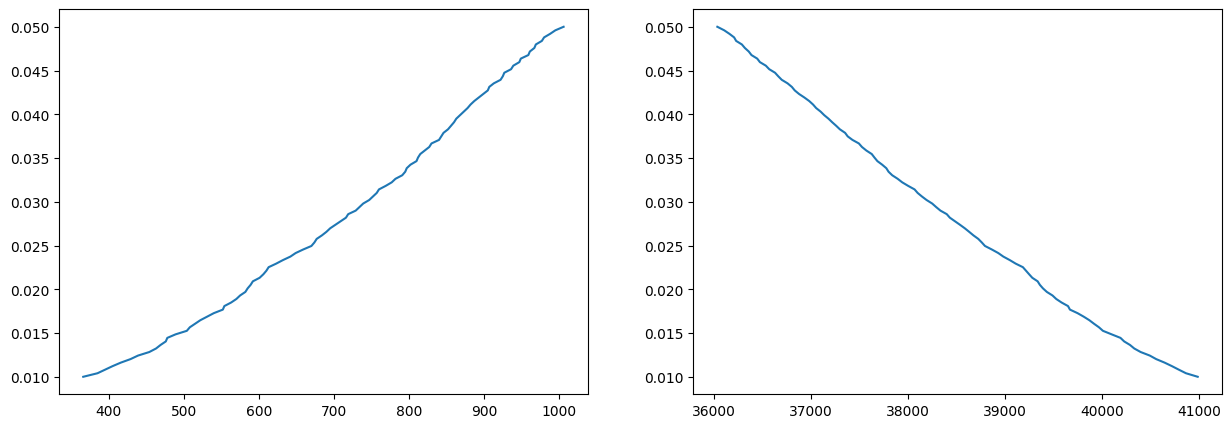

In [7]:
clustering_data.sort_values(by=['num_clusters'])

plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(clustering_data['num_clusters'], clustering_data['km_distance'])

plt.subplot(1,2,2)
plt.plot(clustering_data['num_outliers'], clustering_data['km_distance'])


In [8]:
 clustering = DBSCAN(
        selected_eps, min_samples=5,
        algorithm='ball_tree',
        metric='haversine' # haversine is the distance between two points on a sphere 
        ).fit(np.radians(lat_long_df)) #need to be radians for haversine

In [9]:
_lat_long_df = lat_long_df.copy()
_lat_long_df["cluster"]=clustering.labels_
non_outliner_selector = _lat_long_df["cluster"]!=-1


_lat_long_df = _lat_long_df.loc[non_outliner_selector]
cluster_index = _lat_long_df.index

In [10]:
_lat_long_df

,LATITUDE,LONGITUDE,cluster
12853,-37.972613,145.236357,0
12855,-37.805428,144.943038,1
12892,-37.870664,145.008610,2
12956,-37.686100,144.926795,3
12959,-37.941430,145.166072,4
...,...,...,...
60665,-37.824663,144.963652,413
60668,-37.714850,144.962257,270
60679,-37.643365,144.951194,339
60683,-38.201181,144.311683,344


In [11]:
clusterd_crashsite_df =  crashsite_df.loc[cluster_index].join(_lat_long_df["cluster"])
clusterd_crashsite_df

,X,Y,OBJECTID,ACCIDENT_NO,ABS_CODE,ACCIDENT_STATUS,ACCIDENT_DATE,ACCIDENT_TIME,ALCOHOLTIME,ACCIDENT_TYPE,...,LGA_NAME_ALL,REGION_NAME_ALL,SRNS,SRNS_ALL,RMA,RMA_ALL,DIVIDED,DIVIDED_ALL,STAT_DIV_NAME,cluster
12853,2520758.829,2392048.515,12854,T20160014405,ABS to receive accident,Finished,2016-07-02 00:00:00+00:00,1899/12/30 09:45:00+00,No,Collision with vehicle,...,CASEY,METROPOLITAN SOUTH EAST REGION,M,M,Freeway,"Freeway,Arterial Other",Divided,"Undivided,Divided",Metro,0
12855,2494985.253,2410617.145,12856,T20160014424,ABS to receive accident,Finished,2016-07-02 00:00:00+00:00,1899/12/30 16:17:00+00,Yes,Collision with vehicle,...,MELBOURNE,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Divided,"Undivided,Divided",Metro,1
12892,2500757.571,2403380.220,12893,T20160014549,ABS to receive accident,Finished,2016-07-04 00:00:00+00:00,1899/12/30 19:10:00+00,Yes,Collision with vehicle,...,GLEN EIRA,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Undivided,Undivided,Metro,2
12956,2493546.187,2423857.401,12957,T20160014742,ABS to receive accident,Finished,2016-07-06 00:00:00+00:00,1899/12/30 22:00:00+00,Yes,Collision with vehicle,...,HUME,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Divided,"Divided,Undivided",Metro,3
12959,2514596.618,2395508.245,12960,T20160014776,ABS to receive accident,Finished,2016-07-06 00:00:00+00:00,1899/12/30 21:30:00+00,Yes,Collision with a fixed object,...,DANDENONG,METROPOLITAN SOUTH EAST REGION,A,A,Arterial Highway,"Arterial Highway,Local Road",Divided,"Divided,Undivided",Metro,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60665,2496800.011,2408484.586,60666,T20190020550,ABS to receive accident,Finished,2019-03-23 00:00:00+00:00,1899/12/30 13:55:00+00,No,Collision with vehicle,...,MELBOURNE,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Highway,"Local Road,Arterial Highway",Divided,"Divided,Undivided",Metro,413
60668,2496677.384,2420669.517,60669,T20190021945,ABS to receive accident,Finished,2018-05-08 00:00:00+00:00,1899/12/30 16:28:00+00,No,Collision with vehicle,...,MORELAND,METROPOLITAN NORTH WEST REGION,C,C,Arterial Other,"Arterial Other,Local Road",Divided,"Divided,Undivided",Metro,270
60679,2495690.085,2428609.759,60680,T20200012536,ABS to receive accident,Finished,2019-04-20 00:00:00+00:00,1899/12/30 19:30:00+00,Yes,Collision with vehicle,...,HUME,METROPOLITAN NORTH WEST REGION,C,C,Arterial Other,Arterial Other,Divided,Divided,Metro,339
60683,2439708.262,2366476.020,60684,T20200021601,ABS to receive accident,Unfinished,2019-01-26 00:00:00+00:00,1899/12/30 13:56:00+00,No,Collision with vehicle,...,GEELONG,SOUTH WESTERN REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Country,344


In [12]:
cluster_info_df =  clusterd_crashsite_df.groupby("cluster").agg(
    {
        "TOTAL_PERSONS": "mean",
        "INJ_OR_FATAL": "mean",
        "FATALITY": "mean",
        "SERIOUSINJURY": "mean",
        "OTHERINJURY": "mean",
        "NONINJURED": "mean",
        "LATITUDE": "mean",
        "LONGITUDE": "mean",
        "ACCIDENT_NO": "count"
        
    }
)
cluster_info_df.head()

,TOTAL_PERSONS,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,OTHERINJURY,NONINJURED,LATITUDE,LONGITUDE,ACCIDENT_NO
cluster,,,,,,,,,
0,3.300000,1.200000,0.0,0.400000,0.800000,2.100000,-37.972554,145.236453,10
1,3.125000,1.250000,0.0,0.750000,0.500000,1.750000,-37.805414,144.943047,8
2,2.200000,1.400000,0.0,0.400000,1.000000,0.800000,-37.870666,145.008620,5
3,2.571429,1.285714,0.0,0.285714,1.000000,1.142857,-37.686119,144.926845,7
4,2.714286,1.285714,0.0,0.571429,0.714286,1.428571,-37.941454,145.165959,7


In [13]:

import plotly.express as px
import plotly.graph_objects as go
map_center = cluster_info_df[['LATITUDE', 'LONGITUDE']].mean().values.tolist()

fig = px.scatter_mapbox(cluster_info_df, 
    lat="LATITUDE", lon="LONGITUDE", 
    # hover_name="INJ_OR_FATAL", 
    hover_data=["FATALITY", "SERIOUSINJURY","OTHERINJURY"],
    size=(cluster_info_df["ACCIDENT_NO"]),
    opacity=0.7,
    size_max=50,
    color="INJ_OR_FATAL", 
    zoom=3, height=600)

# add another layer of scatter plot
fig.add_scattermapbox(
    lat=crashsite_df['LATITUDE'],
    lon=crashsite_df['LONGITUDE'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        # x shape
        size=5,
        color='black',
        opacity=0.1
    ),
    hoverinfo='none'
)

fig.add_scattermapbox(
    lat=clusterd_crashsite_df['LATITUDE'],
    lon=clusterd_crashsite_df['LONGITUDE'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=10,
        color=clusterd_crashsite_df['cluster'],
        colorscale='tempo',
        opacity=1
    ),
    hoverinfo='none'
)


fig.update_layout(mapbox_style="white-bg")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.update_layout(mapbox_center={"lat": map_center[0], "lon": map_center[1]})
fig.update_layout(mapbox_zoom=8)
fig.show()
